# Cluster K-means

### Feito por: Jonathas Luis de Sousa
### GCC128-Inteligência Artificial
### Turma 14A


## Carregamento e tratamento do Dataset

Nesta seção se encontra a importação das bibliotecas, inclusive o dataset Iris, direto da biblioteca sklearn.

Além disso, é mostrado alguns metadados do dataset, que alguns auxiliará nos parâmetros do kmeans.

Além do mais, o dataset é convertido em uma etrutura de dados mais simples de ser trabalhada, no caso as listas.

Bibliotecas / Pacotes utilizadas:
  - **sklearn -> datasets:** pacote em que se encontra datasets para estudo de ML;
  - **pandas:** biblioteca de manipulação e análise de dados;
  - **matplotlib -> pyplot:** biblioteca para a vizualização gráfica dos dados;
  - **scipy.spatial -> distance:** biblioteca com funções de calculos de distâncias;
  - **random:** módulo que implementa geradores de números pseudoaleatórios;
  - **numpy:** pacote com uma grande coleção de funções matemáticas



In [1]:
from sklearn import datasets
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial import distance
import random
import numpy as np

In [2]:
# carregamento do dataset iris do sklean
iris = datasets.load_iris()
iris_df=pd.DataFrame(iris.data)
iris_df["classe"] = iris.target
iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid','classe']

iris_df.tail()

,sepal_len,sepal_wid,petal_len,petal_wid,classe
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [3]:
#informações sobre dataFrame
print(iris_df.shape, '\n')
print(iris_df.columns,'\n')
print(iris_df.dtypes)

(150, 5) 

Index(['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'classe'], dtype='object') 

sepal_len    float64
sepal_wid    float64
petal_len    float64
petal_wid    float64
classe         int64
dtype: object


In [4]:
# estatisticas dos dados
iris_df.describe()

,sepal_len,sepal_wid,petal_len,petal_wid,classe
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
#Transformaçao do DataFrame em uma lista, sem a coluna "classe"
dadosIris = iris_df.drop("classe",axis=1).values.tolist()

## Parâmetros

Nesta seção, encontra-se os parâmetros necessários para a execução do algoritmo kmeans, sendo:
- **k:** o numero de clusters;
- **quantidadeColunas:** quantidade de colunas no dataset;
- **limiteSuperior:** lista com valores próximos ao maior valor de cada coluna do dataset, importante para a geração dos centróides;
- **limiteInferior:** lista com valores próximos ao menor valor de cada coluna do dataset, importante para a geração dos centróides;
- **numeroMaximoIteracoes:** numero máximo de vezes em que o loop do algoritmo executará;
- **limiteConvergencia:** valor mínimo das distâncias entre os centróides novos e os antigos, ou seja, a mudança mínima na posição dos centóides.

In [6]:
k = 3
quantidadeColunas = 4
limiteSuperior = [8,5,7,3]
limiteInferior = [4,2,1,0]
numeroMaximoIteracoes = 100
limiteConvergencia = 0.02

## Algoritmo

Algoritmo kmeans e funções auxiliares

### Funções Auxiliares

In [7]:
# cria uma lista com os centroides em posições aleatorias, repeitando os limites dos pontos em cada coluna -> Lista: centroides X coordenadas
def inicializaCentroides():
   centroides = np.random.uniform(limiteInferior,limiteSuperior, (k,quantidadeColunas))
   return np.round(centroides, 2).tolist()

In [8]:
#calcula a distancia euclidiana entre dois pontos, considerando todas as colunas / dimensões
def distanciaEuclidiana(p1,p2):
  return distance.euclidean(p1,p2)

In [9]:
# calcula o ponto médio entre vários pontos -> retorna um ponto que está à mesma distância entre os outros pontos
def calculaPontoMedio(pontos):
  if len(pontos) == 0:
      return [0.0] * quantidadeColunas  # Retorna o ponto na Origem

  numDimensoes = len(pontos[0])  # Obtém o número de dimensões dos pontos
  pontoMedio = [0.0] * numDimensoes  # Inicializa o ponto médio com zeros

  for ponto in pontos:
      for dimensao in range(numDimensoes):
          pontoMedio[dimensao] += ponto[dimensao]

  for dimensao in range(numDimensoes):
      pontoMedio[dimensao] /= len(pontos)

  return pontoMedio

In [10]:
# recalcula a posição dos centróides de acordo com o ponto médio de cada cluster
def recalculaPosicaoCentroides(cluster,centroides):
  centroidesAtualizados = []
  for c in centroides:
    pontos = cluster[centroides.index(c)]
    if len(pontos)!= 0:
      novoCentroide = calculaPontoMedio(pontos)
    else:
      novoCentroide = c # caso não tenha pontos no cluster o centroide não muda de posição
    centroidesAtualizados.append(novoCentroide)
  return centroidesAtualizados

In [11]:
# verifica se houve uma mudança significativa na posição dos centroides
def verificaConvergencia(pontosAnteriores, pontosAtuais):
  for pontoAnterior, pontoAtual in zip(pontosAnteriores, pontosAtuais):
    if distanciaEuclidiana(pontoAnterior, pontoAtual) > limiteConvergencia:
      return True
  return False

In [12]:
#Dado um ponto, retorna a posição, na lista de centroides, do centroide mais próximo do ponto
def centroideMaisProximo(ponto,centroides):
  centroideMaisProximo = -1
  menorDistancia = 999999

  for i in range(0,k):
    distancia = distanciaEuclidiana(ponto,centroides[i])
    if distancia < menorDistancia:
      menorDistancia = distancia
      centroideMaisProximo = i
  return centroideMaisProximo

In [13]:
#cria um cluster vazio, uma lista com k listas vazias
def inicializaClustersVazios():
  cluster = []
  for i in range(k):
    cluster.append(list())
  return cluster

### K-Means

In [14]:
def kMeans(centroides,listaDePontos):
  clusters = [] # Matriz Tri-dimensional -> cluster x itens x coordenadas
  contador = 0 # conta as iterações
  centroidesAtualizados = []

  # enquanto o numero maximo de iterações não for atingido OU enquanto os centroides não convergiram
  while contador < numeroMaximoIteracoes  and (contador == 0 or verificaConvergencia(centroides,centroidesAtualizados)):
    clusters = inicializaClustersVazios()
    if contador != 0:
      centroides = centroidesAtualizados
    # para cada ponto, inseri-lo no cluster referente ao centroide mais proximo
    for ponto in listaDePontos:
      pos = centroideMaisProximo(ponto,centroides)
      clusters[pos].append(ponto)
    contador += 1
    # Atualiza a posição dos centroides
    centroidesAtualizados = recalculaPosicaoCentroides(clusters,centroides)

  return clusters, centroides


In [15]:
centroides = inicializaCentroides()
centroides

[[5.49, 3.05, 5.57, 2.8], [6.53, 2.84, 1.86, 0.05], [5.44, 3.11, 4.73, 2.48]]

In [16]:
clusterizacaoIris,centroides = kMeans(centroides,dadosIris)

## Visualização

In [17]:
def getListThePosition(pos,data):
  lista = list()
  for i in data:
    lista.append(i[pos])
  return lista

In [18]:
def plotResult(position1, position2,xLabel,yLabel,defaultTitle,legendPosition):
  plt.figure(figsize=(12, 5))
  plt.subplot(121)

  plt.scatter(getListThePosition(position1,clusterizacaoIris[0]), getListThePosition(position2,clusterizacaoIris[0]), s = 50, c = 'green', label = '0')
  plt.scatter(getListThePosition(position1,clusterizacaoIris[1]), getListThePosition(position2,clusterizacaoIris[1]), s = 50, c = 'orange', label = '1')
  plt.scatter(getListThePosition(position1,clusterizacaoIris[2]), getListThePosition(position2,clusterizacaoIris[2]), s = 50, c = 'blue', label = '2')
  plt.scatter(getListThePosition(position1,centroides), getListThePosition(position2,centroides), s = 50, c = 'red', label = 'Centroids',  marker='^')
  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  plt.title(defaultTitle + ' - with Kmeans')
  plt.legend(loc=legendPosition)

  plt.subplot(122)
  X = iris.data
  y = iris.target

  setosa = X[y == 0]
  versicolor = X[y == 1]
  virginica = X[y == 2]

  plt.scatter(virginica[:, position1], virginica[:, position2], label='Virginica',  s = 50, c = 'green')
  plt.scatter(versicolor[:, position1], versicolor[:, position2], label='Versicolor', s = 50, c = 'orange')
  plt.scatter(setosa[:, position1], setosa[:, position2], label='Setosa', s = 50, c = 'blue')

  plt.xlabel(xLabel)
  plt.ylabel(yLabel)
  plt.title(defaultTitle)
  plt.legend(loc=legendPosition)

  plt.show()

### Sepal Lenght vs Sepal Width

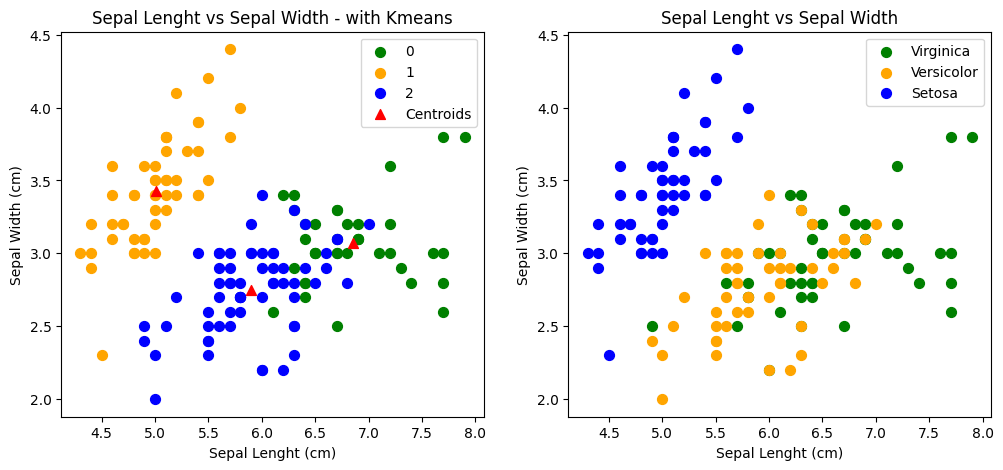

In [19]:
plotResult(0,1,'Sepal Lenght (cm)','Sepal Width (cm)','Sepal Lenght vs Sepal Width','upper right')

### Sepal Lenght vs Petal Width

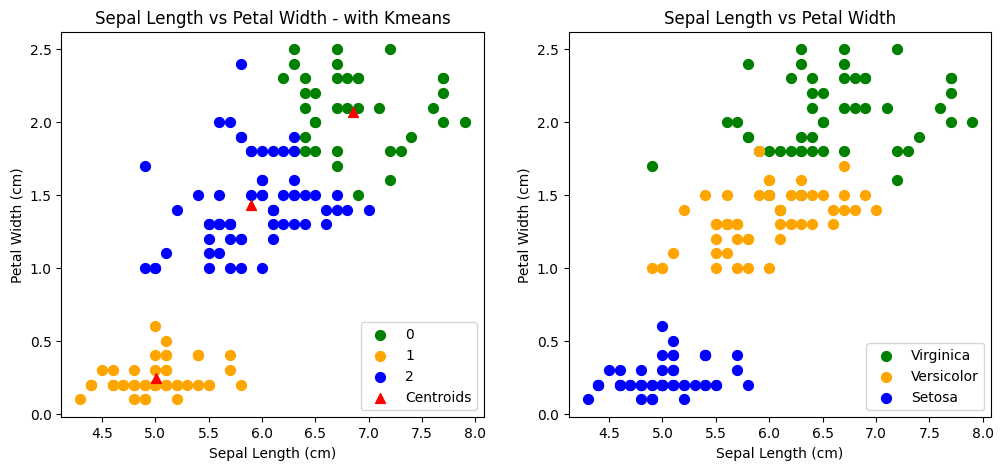

In [20]:
plotResult(0,3,'Sepal Length (cm)','Petal Width (cm)','Sepal Length vs Petal Width','lower right')

### Sepal Width vs Petal Width

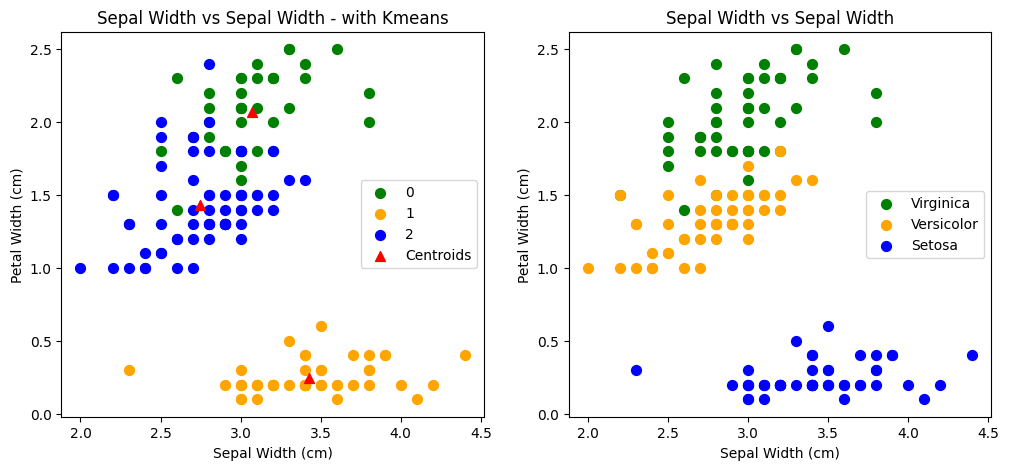

In [21]:
plotResult(1,3,'Sepal Width (cm)','Petal Width (cm)','Sepal Width vs Sepal Width','center right')

### Petal Lenght vs Sepal Lenght

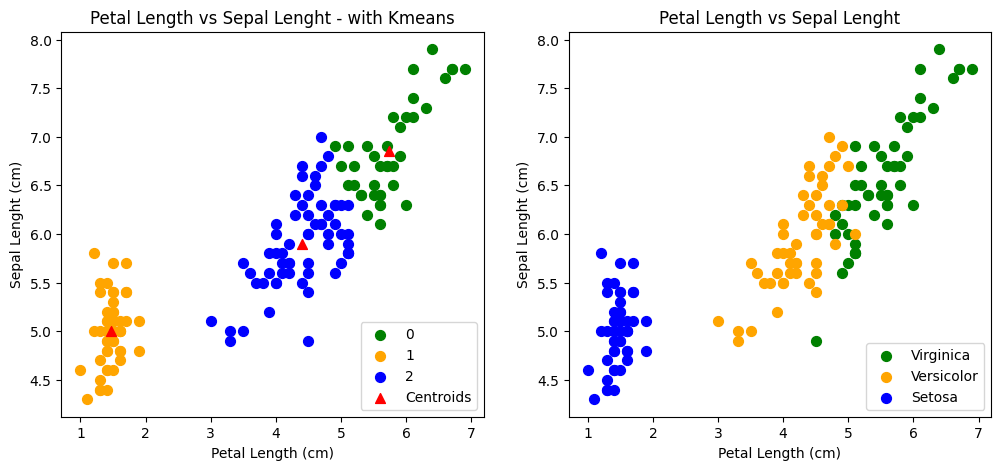

In [22]:
plotResult(2,0,'Petal Length (cm)','Sepal Lenght (cm)','Petal Length vs Sepal Lenght','lower right')

### Petal Length vs Sepal Width

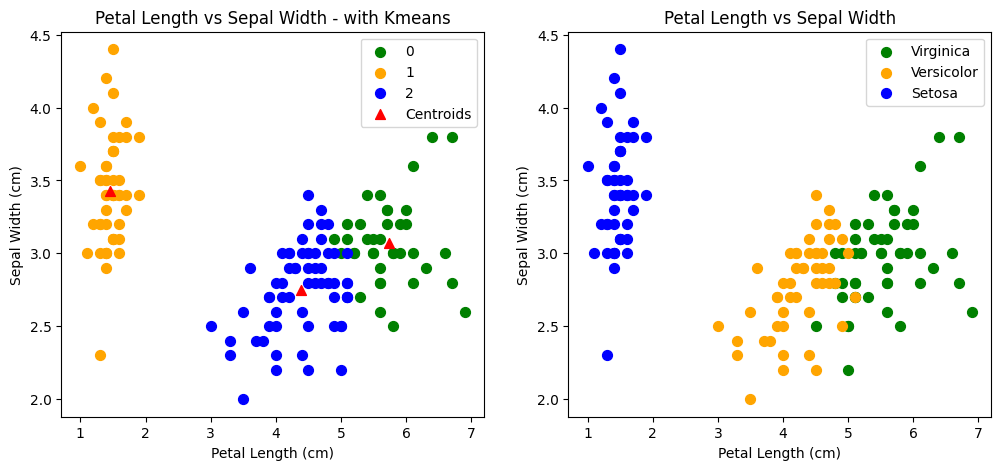

In [23]:
plotResult(2,1,'Petal Length (cm)','Sepal Width (cm)','Petal Length vs Sepal Width','upper right')

### Petal Lenght vs Petal Width

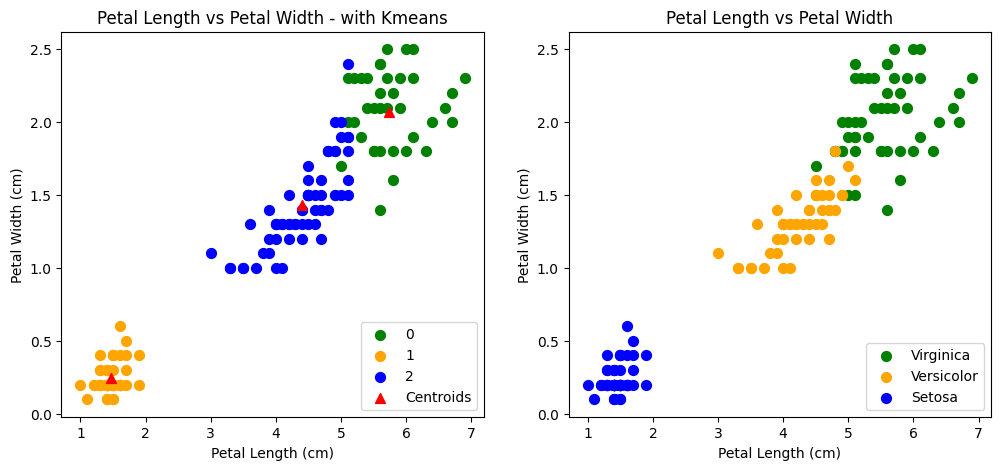

In [24]:
plotResult(2,3,'Petal Length (cm)','Petal Width (cm)','Petal Length vs Petal Width','lower right')